In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from nltk.corpus import stopwords
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, MaxPooling1D, Conv1D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

sw = stopwords.words('english')
warnings.filterwarnings('ignore')
kf = KFold(n_splits=5, shuffle=True)
sns.set_style('darkgrid')

In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train.shape

(7613, 5)

In [4]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
train = train.drop(columns=['id', 'location', 'keyword'])

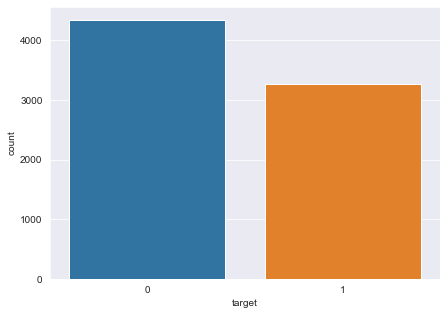

In [6]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train, x='target')

In [7]:
train['target'].value_counts()/train.shape[0]

0    0.57034
1    0.42966
Name: target, dtype: float64

In [8]:
def remove_number(text):
    no_number = re.sub(r'\d+', ' ', text)
    return no_number

def remove_username(text):
    no_username = re.sub(r'\@[^\s]+', ' ', text)
    return no_username

def remove_stopwords(text):
    no_stopwords = [word for word in text.split() if word not in sw]
    return ' '.join(no_stopwords)

def remove_urls(text):
    no_urls = re.sub(r'http[^\s]+', ' ', text)
    return no_urls

def remove_punctuation(text):
    no_punctuation = re.sub(r'[^\w\s]', ' ', text)
    return no_punctuation

def format_text(text):
    no_multiple_spaces = re.sub(r'\s+', ' ', text)
    no_multiple_spaces = no_multiple_spaces.strip()
    return no_multiple_spaces

def remove_one_length_word(text):
    no_one_length_word = re.sub(r'\b[a-z]\b', ' ', text)
    return no_one_length_word

def format_slangs(text):
    text = text.replace("i've", 'i have')
    text = text.replace("i'm", 'i am')
    text = text.replace("what's", 'what is')
    text = text.replace("won't", 'will not')
    text = text.replace("hwy", 'highway')
    text = text.replace("haven't", 'have not')
    text = text.replace("you're", 'you are')
    text = text.replace(" u ", ' you ')
    text = text.replace(" y ", ' why ')
    text = text.replace("im", 'i am')
    return text

def remove_laugh(text):
    no_laugh = re.sub(r'\b(a|e|i)?([ha|he|hi])+(h)?(a|e|i)?\b', ' ', text)
    return no_laugh

def standardization(text):
    no_duplicate_letters= re.sub(r'([a-z])\1+', r'\1', text)
    return no_duplicate_letters

def preprocessing(data):
    data = pd.Series(data)
    data = data.apply(str)
    data = data.apply(lambda x: x.lower())
    data = data.apply(remove_urls)
    data = data.apply(remove_username)
    data = data.apply(remove_number)
    data = data.apply(remove_stopwords)
    data = data.apply(format_slangs)
    data = data.apply(remove_punctuation)
    data = data.apply(remove_one_length_word)
    data = data.apply(standardization)
    data = data.apply(remove_laugh)
    data = data.apply(format_text)
    return data

In [9]:
train['cleaned_text'] = preprocessing(train['text'])
train = train.dropna()
train = train.drop_duplicates()
train = train.reset_index()
train = train.drop(columns=['index'])
train.head()

,text,target,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,deds reason earthquake may alah forgive us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified oficers...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


In [10]:
train.shape

(7521, 3)

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['cleaned_text'])

In [12]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

13821


In [13]:
train['tokenized_text'] = tokenizer.texts_to_sequences(train['cleaned_text'])
train['tokenized_text'].head()

0                 [4195, 737, 164, 60, 1584, 4196, 24]
1                 [105, 5, 145, 643, 6183, 6184, 1077]
2    [1585, 1458, 1757, 589, 6185, 1586, 188, 1757,...
3                      [11, 4197, 1341, 188, 1250, 27]
4    [32, 1078, 236, 6186, 1758, 171, 1341, 6187, 106]
Name: tokenized_text, dtype: object

In [14]:
X = train['tokenized_text']
y = train['target']

In [15]:
def words_per_text(text):
    text = str(text)
    return len(text.split())

In [16]:
temp = pd.DataFrame()
temp['depois'] = train['cleaned_text'].apply(words_per_text)
temp['antes'] = train['text'].apply(words_per_text)

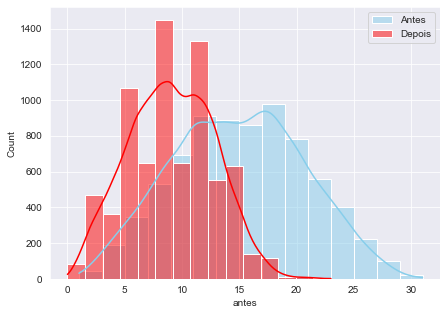

In [17]:
plt.figure(figsize=(7, 5))
sns.histplot(data=temp, x="antes", color="skyblue", label="Antes", bins=15, kde=True)
sns.histplot(data=temp, x="depois", color="red", label="Depois", bins=15, kde=True)
plt.legend() 
plt.show()

In [18]:
print("Antes: {}, Depois: {}".format(temp['antes'].mean(), temp['depois'].mean()))
del temp

Antes: 14.88020210078447, Depois: 9.085228028187741


In [19]:
X = pad_sequences(X, maxlen=10, padding='post')

In [20]:
accuracies = []
losses = []
k = list(range(1, 6))

for train, test in kf.split(X, y):
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=100, 
                        input_length=10))
    model.add(Conv1D(32, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(64, 5, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X[train], y[train], epochs=5, batch_size=32)
    score = model.evaluate(X[test], y[test])
    accuracies.append(score[1])
    losses.append(score[0])
    print('\n-----------------------\n')

Epoch 1/5
188/188 [==============================] - 18s 28ms/step - loss: 0.6475 - accuracy: 0.6631
Epoch 2/5
188/188 [==============================] - 5s 28ms/step - loss: 0.3063 - accuracy: 0.8816
Epoch 3/5
188/188 [==============================] - 5s 29ms/step - loss: 0.1715 - accuracy: 0.9448
Epoch 4/5
188/188 [==============================] - 5s 29ms/step - loss: 0.1115 - accuracy: 0.9665
Epoch 5/5
48/48 [==============================] - 1s 2ms/step - loss: 0.7793 - accuracy: 0.7216

-----------------------

Epoch 1/5
189/189 [==============================] - 6s 27ms/step - loss: 0.6380 - accuracy: 0.6307
Epoch 2/5
189/189 [==============================] - 5s 27ms/step - loss: 0.2983 - accuracy: 0.8827
Epoch 3/5
189/189 [==============================] - 5s 28ms/step - loss: 0.1496 - accuracy: 0.9477
Epoch 4/5
189/189 [==============================] - 5s 28ms/step - loss: 0.0893 - accuracy: 0.9744
Epoch 5/5
47/47 [==============================] - 0s 2ms/step - loss: 0.715

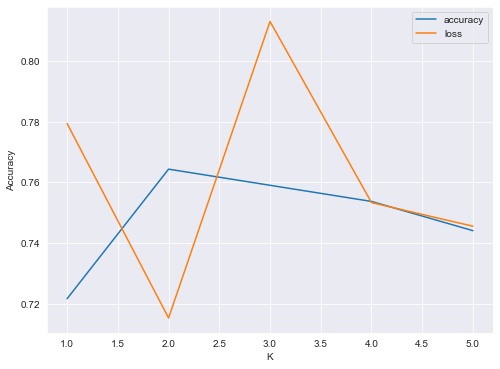

In [21]:
results = pd.DataFrame({
    'K': k,
    'Accuracy': accuracies,
    'Loss': losses
})

plt.figure(figsize=(8, 6))
sns.lineplot(data=results, x='K', y='Accuracy', label='accuracy')
sns.lineplot(data=results, x='K', y='Loss', label='loss')
plt.legend()
plt.show()

In [22]:
test = pd.read_csv('test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [23]:
id_test = test['id']
test = test.drop(columns=['id', 'keyword', 'location'])

In [24]:
test['cleaned_text'] = preprocessing(test['text'])
test.head()

,text,cleaned_text
0,Just happened a terrible car crash,hapened terible car crash
1,"Heard about #earthquake is different cities, s...",heard earthquake diferent cities stay safe eve...
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond gese fleing acros stret ...
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan,typhon soudelor kils china taiwan


In [25]:
test.shape

(3263, 2)

In [26]:
test['tokenized_text'] = tokenizer.texts_to_sequences(test['cleaned_text'])
test['tokenized_text'].head()

0                               [782, 1774, 53, 29]
1            [369, 164, 1059, 2412, 489, 1871, 125]
2    [105, 5, 686, 3250, 4651, 739, 619, 1257, 322]
3                           [347, 3581, 6544, 1341]
4                        [131, 582, 372, 241, 1067]
Name: tokenized_text, dtype: object

In [27]:
test = pad_sequences(test['tokenized_text'], maxlen=10, padding='post')
test

array([[ 782, 1774,   53, ...,    0,    0,    0],
       [ 369,  164, 1059, ...,    0,    0,    0],
       [ 105,    5,  686, ..., 1257,  322,    0],
       ...,
       [ 830,  557,  384, ...,    0,    0,    0],
       [5703,  482,  357, ...,    0,    0,    0],
       [2588, 1450,   15, ...,    0,    0,    0]], dtype=int32)

In [28]:
prediction = model.predict_classes(test, batch_size=32)
predicted = [p[0][0] for p in prediction]
predicted

[1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [29]:
results = pd.DataFrame()
results['id'] = id_test
results['target'] = predicted
results.to_csv('submission_cnn.csv', index=False)